In [1]:
import sys
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [2]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 13:34:09] [setup] RAM Tracking...
[codecarbon INFO @ 13:34:09] [setup] GPU Tracking...
[codecarbon INFO @ 13:34:09] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:34:09] [setup] CPU Tracking...
[codecarbon WARNING @ 13:34:09] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 13:34:12] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 13:34:12] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 13:34:12] >>> Tracker's metadata:
[codecarbon INFO @ 13:34:12]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 13:34:12]   Python version: 3.11.3
[codecarbon INFO @ 13:34:12]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 13:34:12]   Available RAM : 256.000 GB
[codecarbon INFO @ 13:34:12]   CPU count: 24
[codecarbon INFO @ 13:34:12]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [3]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [4]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [6]:
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [7]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


n17wvb3ltq0a


In [8]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [11]:
import pandas as pd
path_to_files = "/fp/projects01/ec307/ec-krimhau/github_datasets/HP_vs_med_low"
file_name = "high_vs_med_low_top_50_hp_repos_balanced_github.csv"
full_training_df = pd.read_csv(f"{path_to_files}/{file_name}")
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [12]:
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [13]:
import pandas as pd
fine_tuning_df = pd.read_csv("clean_high_vs_med_low_mypy_testset.csv")
fine_tuning_df

,text,label
0,name resolution in mypy doesnt match python fo...,1
1,support indexing and iterating enum type objec...,1
2,new semantic analyzer invalid type variable pr...,0
3,parameterless generic functions are allowed py...,0
4,support type aliases in finegrained incrementa...,1
...,...,...
729,error codes in type ignore dont suppress relat...,1
730,crash on unpacking to member expression this t...,1
731,give better error messages when calling overlo...,1
732,two issues with subclassing namedtuplegenerate...,1


In [14]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [15]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [16]:
fine_tune_train_df

,text,label
559,make mypy more positive maybe someone already ...,0
33,false positive for union tuple the following c...,0
275,use plugin to support numpy this was originall...,0
198,support pep syntax for runtime use cases this ...,1
192,if list item has incompatible type display exp...,1
...,...,...
209,union is not processed correctly if its mentio...,0
568,forward reference to typinglist results in any...,1
412,x tuple type tuple incompatible types in assig...,0
176,add hover text with explanations to html repor...,0


In [17]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [18]:
df

,label,text
0,0,use correct case for help documentation in eg ...
1,0,overwriting bookmark folders when syncing devi...
2,0,no results if country is specified in the quer...
3,0,prepopulate subject of message when clicking r...
4,0,timeout on wiki listoffeaturedimages does not ...
...,...,...
36450,0,union is not processed correctly if its mentio...
36451,1,forward reference to typinglist results in any...
36452,0,x tuple type tuple incompatible types in assig...
36453,0,add hover text with explanations to html repor...


In [19]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [20]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        6077
       0        6075
1      1        6102
       0        6050
2      0        6113
       1        6038
Name: count, dtype: int64

In [21]:
df

,label,text,kfold
0,0,use correct case for help documentation in eg ...,0
1,0,overwriting bookmark folders when syncing devi...,2
2,0,no results if country is specified in the quer...,1
3,0,prepopulate subject of message when clicking r...,1
4,0,timeout on wiki listoffeaturedimages does not ...,1
...,...,...,...
36450,0,union is not processed correctly if its mentio...,0
36451,1,forward reference to typinglist results in any...,1
36452,0,x tuple type tuple incompatible types in assig...,2
36453,0,add hover text with explanations to html repor...,2


In [22]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [23]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [24]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [25]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [26]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [27]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [29]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [30]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [31]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [32]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [33]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 760/760 [02:02<00:00,  6.19it/s, Epoch=1, LR=9.88e-6, Valid_Loss=0.522]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6782    0.8897    0.7697      6075
          HP     0.8398    0.5779    0.6847      6077

    accuracy                         0.7338     12152
   macro avg     0.7590    0.7338    0.7272     12152
weighted avg     0.7590    0.7338    0.7272     12152

Accuracy = 0.7338
F1_score = 0.6847
Validation Loss Improved (inf ---> 0.5217418662217826)
Model Saved



100%|██████████| 760/760 [02:02<00:00,  6.18it/s, Epoch=2, LR=9.52e-6, Valid_Loss=0.543]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6575    0.9491    0.7769      6075
          HP     0.9087    0.5058    0.6499      6077

    accuracy                         0.7275     12152
   macro avg     0.7831    0.7275    0.7134     12152
weighted avg     0.7831    0.7275    0.7134     12152

Accuracy = 0.7275
F1_score = 0.6499



100%|██████████| 760/760 [02:02<00:00,  6.18it/s, Epoch=3, LR=8.95e-6, Valid_Loss=0.538]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6928    0.9225    0.7913      6075
          HP     0.8841    0.5911    0.7085      6077

    accuracy                         0.7567     12152
   macro avg     0.7884    0.7568    0.7499     12152
weighted avg     0.7884    0.7567    0.7499     12152

Accuracy = 0.7567
F1_score = 0.7085

Training complete in 1h 0m 53s
Best Loss: 0.5217


Train Loss,█▃▁
Valid Accuracy,▃▁█
Valid F1_score,▅▁█
Valid Loss,▁█▆
Best Loss,0.52174
Train Loss,0.41505
Valid Accuracy,0.7567
Valid F1_score,0.7085
Valid Loss,0.53761



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 760/760 [02:05<00:00,  6.08it/s, Epoch=1, LR=9.88e-6, Valid_Loss=0.537]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.8007    0.6031    0.6880      6050
          HP     0.6839    0.8512    0.7584      6102

    accuracy                         0.7277     12152
   macro avg     0.7423    0.7272    0.7232     12152
weighted avg     0.7421    0.7277    0.7234     12152

Accuracy = 0.7277
F1_score = 0.7584
Validation Loss Improved (inf ---> 0.5373212426920483)
Model Saved



100%|██████████| 760/760 [02:04<00:00,  6.08it/s, Epoch=2, LR=9.52e-6, Valid_Loss=0.466]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7660    0.7769    0.7714      6050
          HP     0.7756    0.7647    0.7701      6102

    accuracy                         0.7707     12152
   macro avg     0.7708    0.7708    0.7707     12152
weighted avg     0.7708    0.7707    0.7707     12152

Accuracy = 0.7707
F1_score = 0.7701
Validation Loss Improved (0.5373212426920483 ---> 0.46575491254937107)
Model Saved



100%|██████████| 760/760 [02:05<00:00,  6.08it/s, Epoch=3, LR=8.95e-6, Valid_Loss=0.504]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7087    0.8993    0.7927      6050
          HP     0.8639    0.6336    0.7310      6102

    accuracy                         0.7659     12152
   macro avg     0.7863    0.7665    0.7619     12152
weighted avg     0.7867    0.7659    0.7618     12152

Accuracy = 0.7659
F1_score = 0.731

Training complete in 0h 52m 20s
Best Loss: 0.4658


Train Loss,█▃▁
Valid Accuracy,▁█▇
Valid F1_score,▆█▁
Valid Loss,█▁▅
Best Loss,0.46575
Train Loss,0.40728
Valid Accuracy,0.7659
Valid F1_score,0.731
Valid Loss,0.50448



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 760/760 [02:05<00:00,  6.08it/s, Epoch=1, LR=9.87e-6, Valid_Loss=0.504]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7057    0.8510    0.7716      6113
          HP     0.8094    0.6408    0.7153      6038

    accuracy                         0.7465     12151
   macro avg     0.7576    0.7459    0.7434     12151
weighted avg     0.7573    0.7465    0.7436     12151

Accuracy = 0.7465
F1_score = 0.7153
Validation Loss Improved (inf ---> 0.5039326117103673)
Model Saved



100%|██████████| 760/760 [02:05<00:00,  6.07it/s, Epoch=2, LR=9.5e-6, Valid_Loss=0.499]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.8049    0.6815    0.7381      6113
          HP     0.7209    0.8327    0.7728      6038

    accuracy                         0.7566     12151
   macro avg     0.7629    0.7571    0.7554     12151
weighted avg     0.7631    0.7566    0.7553     12151

Accuracy = 0.7566
F1_score = 0.7728
Validation Loss Improved (0.5039326117103673 ---> 0.4993224293520868)
Model Saved



100%|██████████| 760/760 [02:05<00:00,  6.07it/s, Epoch=3, LR=8.89e-6, Valid_Loss=0.491]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.8080    0.7075    0.7544      6113
          HP     0.7370    0.8297    0.7806      6038

    accuracy                         0.7682     12151
   macro avg     0.7725    0.7686    0.7675     12151
weighted avg     0.7727    0.7682    0.7674     12151

Accuracy = 0.7682
F1_score = 0.7806
Validation Loss Improved (0.4993224293520868 ---> 0.49120073001940606)
Model Saved

Training complete in 0h 47m 38s
Best Loss: 0.4912


Train Loss,█▃▁
Valid Accuracy,▁▄█
Valid F1_score,▁▇█
Valid Loss,█▅▁
Best Loss,0.4912
Train Loss,0.40214
Valid Accuracy,0.7682
Valid F1_score,0.7806
Valid Loss,0.4912


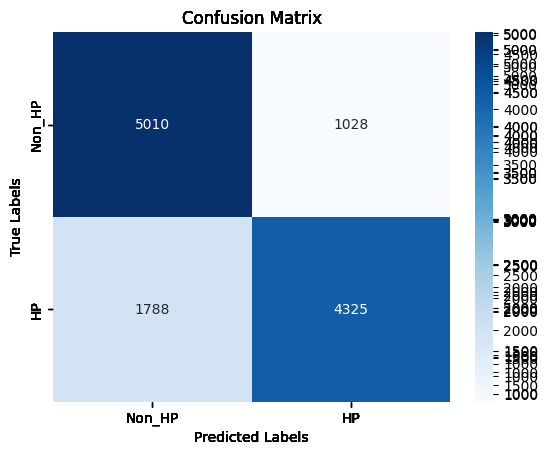

In [34]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [35]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [36]:
test_df = fine_tune_test_df

In [37]:
test_df

,text,label
264,behaviour of not annotated init on inheritance...,0
536,union of a class with any base and none is som...,1
259,error cannot redefine t as a type variable wit...,0
137,support function decorators excellently decora...,0
227,prohibit issubclass for runtime protocols with...,0
...,...,...
71,better type for self in untyped functions runn...,0
106,internal error when using assignment expressio...,1
270,noimplicitreexport should treat names in all a...,1
435,enum final checking false positive in complex ...,1


In [38]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [39]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [40]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [41]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [42]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [43]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 33/33 [00:05<00:00,  6.25it/s]


Fold 1


100%|██████████| 33/33 [00:05<00:00,  6.30it/s]


Fold 2


100%|██████████| 33/33 [00:05<00:00,  6.31it/s]


In [44]:
deberta_predictions


[array([[0.5719163 , 0.4280837 ],
        [0.57818645, 0.42181352],
        [0.24460849, 0.75539154],
        ...,
        [0.69053555, 0.30946448],
        [0.55178636, 0.44821367],
        [0.6782048 , 0.3217952 ]], dtype=float32),
 array([[0.56513345, 0.43486658],
        [0.30590877, 0.69409126],
        [0.5787353 , 0.42126468],
        ...,
        [0.8592156 , 0.14078435],
        [0.08581269, 0.91418725],
        [0.46962404, 0.5303759 ]], dtype=float32),
 array([[0.5011364 , 0.49886358],
        [0.16670102, 0.8332989 ],
        [0.4797356 , 0.5202644 ],
        ...,
        [0.80200523, 0.19799481],
        [0.06168047, 0.93831944],
        [0.66956   , 0.33043998]], dtype=float32)]

In [45]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.54606205, 0.45393792],
       [0.3502654 , 0.64973456],
       [0.4343598 , 0.5656402 ],
       ...,
       [0.7839188 , 0.21608122],
       [0.23309319, 0.76690674],
       [0.6057963 , 0.39420366]], dtype=float32)

In [46]:
len(predictions)

514

In [47]:
predictions

array([[0.54606205, 0.45393792],
       [0.3502654 , 0.64973456],
       [0.4343598 , 0.5656402 ],
       ...,
       [0.7839188 , 0.21608122],
       [0.23309319, 0.76690674],
       [0.6057963 , 0.39420366]], dtype=float32)

In [48]:
test_df["prediction_0"] = predictions[:, 0] 

In [49]:
test_df["prediction_1"] = predictions[:, 1] 

In [50]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [51]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
264,behaviour of not annotated init on inheritance...,0,0.546062,0.453938,0,0,0
536,union of a class with any base and none is som...,1,0.350265,0.649735,0,1,1
259,error cannot redefine t as a type variable wit...,0,0.434360,0.565640,1,0,1
137,support function decorators excellently decora...,0,0.521325,0.478675,0,1,0
227,prohibit issubclass for runtime protocols with...,0,0.621966,0.378034,0,0,0
...,...,...,...,...,...,...,...
71,better type for self in untyped functions runn...,0,0.750634,0.249365,0,0,0
106,internal error when using assignment expressio...,1,0.270699,0.729301,1,1,1
270,noimplicitreexport should treat names in all a...,1,0.783919,0.216081,0,0,0
435,enum final checking false positive in complex ...,1,0.233093,0.766907,0,1,1


In [52]:
len(test_df)

514

In [53]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [54]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [55]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [56]:
test_df["pred"] = test_df["pred"].astype(int)

In [57]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
264,behaviour of not annotated init on inheritance...,0,0.546062,0.453938,0,0,0,prediction_0,0
536,union of a class with any base and none is som...,1,0.350265,0.649735,0,1,1,prediction_1,1
259,error cannot redefine t as a type variable wit...,0,0.434360,0.565640,1,0,1,prediction_1,1
137,support function decorators excellently decora...,0,0.521325,0.478675,0,1,0,prediction_0,0
227,prohibit issubclass for runtime protocols with...,0,0.621966,0.378034,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
71,better type for self in untyped functions runn...,0,0.750634,0.249365,0,0,0,prediction_0,0
106,internal error when using assignment expressio...,1,0.270699,0.729301,1,1,1,prediction_1,1
270,noimplicitreexport should treat names in all a...,1,0.783919,0.216081,0,0,0,prediction_0,0
435,enum final checking false positive in complex ...,1,0.233093,0.766907,0,1,1,prediction_1,1


In [58]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[169  88]
 [ 85 172]]


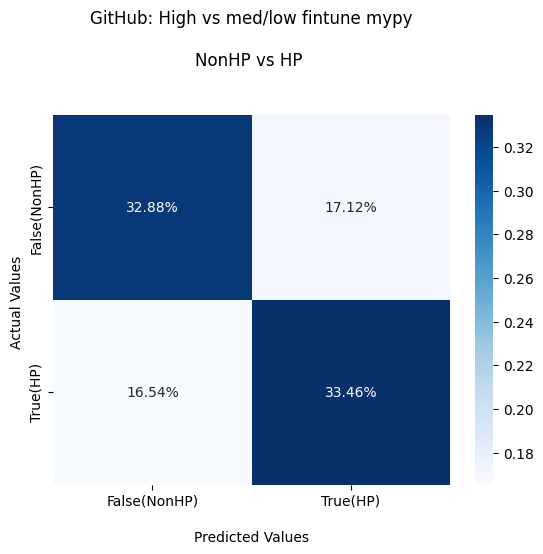

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('GitHub: High vs med/low fintune mypy\n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [60]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.67      0.66      0.66       257
           1       0.66      0.67      0.67       257

    accuracy                           0.66       514
   macro avg       0.66      0.66      0.66       514
weighted avg       0.66      0.66      0.66       514



In [61]:
test_df[["text","label","pred"]].to_csv("mypy_70_Test_inference.csv")

In [62]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.3268705198784323


In [63]:
tracker.stop()

0.025957747939053935